In [1]:
import config
import time

import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi

from neo4j import GraphDatabase

In [11]:
# set up connection
driver = GraphDatabase.driver(config.uri, auth=(config.user, config.password), encrypted=False)

# Check if connection did work
def check_connectivity(driver):
    try:
        with driver.session() as session:
            result = session.run("RETURN 1 as result")
            record = result.single()
            if record and record["result"] == 1:
                return True
            else:
                print('False')
                return False
    except Exception as e:
        return False


if check_connectivity(driver):
    print("Verbindung erfolgreich hergestellt.")
else:
    print("Fehler bei der Verbindungsherstellung.")

Verbindung erfolgreich hergestellt.


# Graph Database Algorithm

## Projection

In [12]:
def drop_projection() -> None:
    """
    Drop the projection of the graph.
    """
    with driver.session() as session:
        drop_projection_query = "CALL gds.graph.drop('gene_protein_graph')"
        
        session.run(drop_projection_query)
        print("Projection dropped.")

def create_projection() -> None:
    """
    Create a projection of the graph for the gene and protein nodes.
    """
    with driver.session() as session:
        projection_query = """
        CALL gds.graph.project(
            'gene_protein_graph',
            {
                gene: {
                    label: 'gene'
                },
                protein: {
                    label: 'protein'
                }
            },
            {
                INTERACTS: {
                    type: 'INTERACTS',
                    orientation: 'UNDIRECTED'
                },
                CONNECTION: {
                    type: 'CONNECTION',
                    orientation: 'UNDIRECTED'
                }
            }
        )
        """
        
        session.run(projection_query)
        print("Graph projection created.")

# drop_projection()
create_projection()

Graph projection created.


## Helper Functions

In [13]:
def drop_protein_nodes(df) -> pd.DataFrame:
    """
    Drop the protein nodes from the dataframe.
    :param df: The dataframe with the protein nodes.
    """
    return df[~df["id"].str.contains("ENSP")]
    
    

## Pagerank

In [14]:
def run_pagerank() -> pd.DataFrame:
    """
    Pagerank algorithm performed on the genes.
    :return: 
    """
    with driver.session() as session:
        query = """
        CALL gds.pageRank.stream('gene_protein_graph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).id AS Gene ID,
               gds.util.asNode(nodeId).gene_name AS Gene Name,
               score, 
               gds.util.asNode(nodeId).Δ_TPM AS Δ TPM,
               gds.util.asNode(nodeId).Δ_TPM_relevant AS Δ TPM relevant
        ORDER BY score DESC
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
        
        df_results["score"] = df_results["score"].round(3)
    
        return df_results

start = time.time()

df_pagerank = run_pagerank()

end = time.time()
print(f"Time taken: {round(end - start, 0)} seconds.")

Time taken: 6.0 seconds.


In [20]:
print("Only genes nodes:")
df_pagerank.head(100)

Only genes nodes:


,id,gene_name,score,Δ_TPM,Δ_TPM_relevant
0,ENSG00000109339,MAPK10,67.209,-0.051677,False
1,ENSG00000115392,FANCL,40.200,0.149585,False
2,ENSG00000107862,GBF1,37.993,0.034794,False
3,ENSG00000145362,ANK2,36.668,-0.025229,False
4,ENSG00000121940,CLCC1,34.903,0.028258,False
...,...,...,...,...,...
101,ENSG00000103034,NDRG4,16.373,-0.128267,False
102,ENSG00000103811,CTSH,16.373,-0.056641,False
103,ENSG00000173230,GOLGB1,16.373,0.031236,False
104,ENSG00000146282,RARS2,16.373,0.079608,False


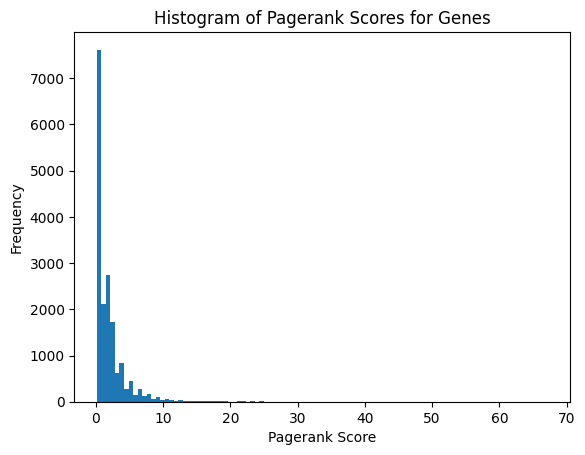

In [17]:
plt.hist(df_pagerank["score"], bins=100)
plt.xlabel("Pagerank Score")
plt.ylabel("Frequency")
plt.title("Histogram of Pagerank Scores for Genes")

plt.savefig('../tex/figures/03_03_hist_pagerank.png')
plt.show()

### Relevant Genes

In [18]:
print("Only genes with cancer active nodes:")
df_pagerank_relevant = df_pagerank.where(df_pagerank["Δ_TPM_relevant"] == True).dropna()

# save the dataframe as an image
dfi.export(df_pagerank_relevant.reset_index(drop=True).head(10), '../tex/figures/03_03_df_pagerank_relevant.png')

df_pagerank_relevant.head(10)

Only genes with cancer active nodes:


,id,gene_name,score,Δ_TPM,Δ_TPM_relevant
22,ENSG00000165795,NDRG2,25.635,-0.317776,True
57,ENSG00000161249,DMKN,19.901,-0.203997,True
76,ENSG00000092529,CAPN3,18.136,-0.310797,True
157,ENSG00000157103,SLC6A1,14.170,-0.267816,True
170,ENSG00000110436,SLC1A2,13.729,-0.233129,True
189,ENSG00000012048,BRCA1,13.289,0.214719,True
196,ENSG00000022267,FHL1,12.850,-0.217644,True
206,ENSG00000197971,MBP,12.849,-0.296146,True
284,ENSG00000049540,ELN,11.119,-0.246766,True
291,ENSG00000172995,ARPP21,11.090,-0.201848,True


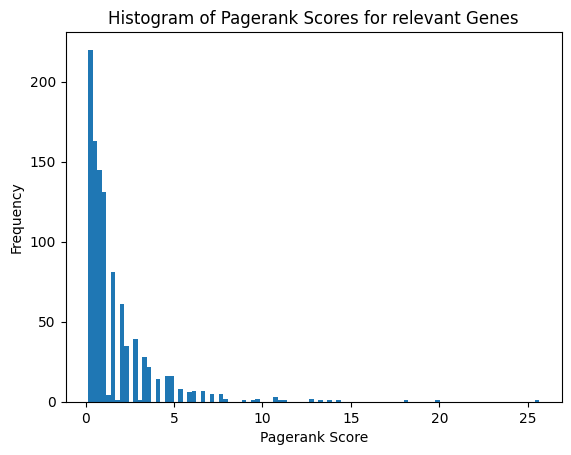

In [19]:
plt.hist(df_pagerank_relevant["score"], bins=100)
plt.xlabel("Pagerank Score")
plt.ylabel("Frequency")
plt.title("Histogram of Pagerank Scores for relevant Genes")

plt.savefig('../tex/figures/03_03_hist_pagerank_relevant.png')
plt.show()

 ## Clustering / Community Detection
### Louvain algorithm

In [ ]:
# stop here
breakpoint()

In [ ]:
def run_louvain() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.louvain.stream('gene_protein_graph')
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               communityId,
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).delta_tpm_relevant AS delta_tpm_relevant
        ORDER BY communityId
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results
    
df_louvain = run_louvain()

In [ ]:
df_louvain

In [ ]:
# number of communities
print(f'Number of communities in general: \t\t\t\t{df_louvain["communityId"].nunique()}')

# group by communityId and count the number of cancer active nodes and the total number of nodes
df_louvain_agg = df_louvain.groupby("communityId").agg({"delta_tpm_relevant": "sum", "node": "count"})

# drop communities with a single node
df_louvain_agg = df_louvain_agg.where(df_louvain_agg["node"] > 1).dropna()

print(f'Number of communities with more then a single node: \t{df_louvain_agg.shape[0]}')

In [ ]:
# calculate the ratio of cancer active nodes to the total number of nodes
df_louvain_agg["ratio"] = df_louvain_agg["delta_tpm_relevant"] / df_louvain_agg["node"]

print("Communities with delta tpm relevant nodes:")
df_louvain_agg

In [ ]:
# TODO And now?